# Testing
## Bevölkerung nach Geburtsort und Geburtsland

Beschreibung
Wirtschaftliche Wohnbevölkerung der Stadt Zürich nach Geburtsort und Geburtsland. Personen, die im Ausland geboren sind, haben lediglich Angaben zum Geburtsland. Bei den in der Schweiz geborenen, werden die Geburtsorte auf Gemeindeebene angegeben. Die Gemeindekoordinatenpunkte werden ebenfalls mitgeliefert.

Datum: 15.03.2022

Am **19.9.2022** hat Philipp für APD entschieden, dass künftig **keine Koordinaten** für die Gemeindemittelpunkte mehr mitgeliefert werden. Dies kann mit LOD ja unterdessen einfach von Swisstopo bezogen werden. 



### Importiere die notwendigen Packages

In [1]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [2]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
import leafmap

import requests
import io


In [3]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [4]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [5]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [6]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [7]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 9 datenstand:  7 time.struct_time(tm_year=2022, tm_mon=9, tm_mday=19, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=0, tm_yday=262, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [8]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [9]:
package_name = "bev_bestand_jahr_gemeinde_land_geburtsort_od3380"

In [10]:
dataset_name = "BEV338OD3380.csv"

**Statische Pfade in DWH-Dropzones**

In [11]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [12]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [13]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [14]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [15]:
from IPython.display import Markdown as md

In [16]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_bestand_jahr_gemeinde_land_geburtsort_od3380 

In [17]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_gemeinde_land_geburtsort_od3380 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [20]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "integ"; #prod vs something else
data_source = "dropzone"; #dropzone vs something else
print(status+" - "+ data_source)

integ - dropzone


In [21]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bev_bestand_jahr_gemeinde_land_geburtsort_od3380\BEV338OD3380.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [22]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['StichtagDatJahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

data2betested.dtypes

dropzone


StichtagDatJahr    datetime64[ns]
GebOrtHistCd                int64
GebOrtHistLang             object
GebLandHistCd               int64
GebLandHistLang            object
AnzBestWir                  int64
dtype: object

Berechne weitere Attribute falls notwendig

In [23]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr_str = lambda x: x.StichtagDatJahr.astype(str),
    )
    .sort_values('StichtagDatJahr', ascending=False)
    )
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
GebOrtHistCd                    int64
GebOrtHistLang                 object
GebLandHistCd                   int64
GebLandHistLang                object
AnzBestWir                      int64
StichtagDatJahr_str            object
dtype: object

### Einfache Datentests

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [24]:
data2betested.head(2)

,StichtagDatJahr,GebOrtHistCd,GebOrtHistLang,GebLandHistCd,GebLandHistLang,AnzBestWir,StichtagDatJahr_str
68095,2021-01-01,9999,Ausland,8702,Bouvetinsel,1,2021-01-01
66752,2021-01-01,3371,Brunnadern,8100,Schweiz,3,2021-01-01


In [25]:
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
GebOrtHistCd                    int64
GebOrtHistLang                 object
GebLandHistCd                   int64
GebLandHistLang                object
AnzBestWir                      int64
StichtagDatJahr_str            object
dtype: object

In [26]:
data2betested.shape

(68096, 7)

Beschreibe einzelne Attribute

In [27]:
data2betested.describe()

,GebOrtHistCd,GebLandHistCd,AnzBestWir
count,68096,68096,68096
mean,3659,8125,164
std,2713,90,2640
min,1,8100,0
25%,1132,8100,2
50%,3582,8100,6
75%,5145,8100,18
max,9999,9999,126647


#### Missings?

Wie viele Nullwerte gibt es im Datensatz?

In [29]:
data2betested.isnull().sum()

StichtagDatJahr        0
GebOrtHistCd           0
GebOrtHistLang         0
GebLandHistCd          0
GebLandHistLang        0
AnzBestWir             0
StichtagDatJahr_str    0
dtype: int64

Viele Missings stammen daher, dass wir keine Koordinaten zu Ländern haben. Aus der Schweiz sollte es aber keine geben...

In [32]:
ch_missings = data2betested.query('GebLandHistLang=="Schweiz"')
ch_missings[ch_missings['GebLandHistCd'].isna()]

,StichtagDatJahr,GebOrtHistCd,GebOrtHistLang,GebLandHistCd,GebLandHistLang,AnzBestWir,StichtagDatJahr_str


#### Zwischenschritt optional - siehe dazu das Verzeichnis «update_ogd» > ch_gemeinde_centroide

Wechsle dazu in das update_ogd Verzeichnis

---------------------------------------------------------------------------------------------

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [33]:
data2betested = data2betested.set_index("StichtagDatJahr")

In [34]:
data2betested.info()
data2betested.index.year.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68096 entries, 2021-01-01 to 1993-01-01
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   GebOrtHistCd         68096 non-null  int64 
 1   GebOrtHistLang       68096 non-null  object
 2   GebLandHistCd        68096 non-null  int64 
 3   GebLandHistLang      68096 non-null  object
 4   AnzBestWir           68096 non-null  int64 
 5   StichtagDatJahr_str  68096 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.6+ MB


Int64Index([2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008,
            2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994,
            1993],
           dtype='int64', name='StichtagDatJahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [86]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [35]:
data2betested.loc["2021"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,GebOrtHistCd,GebOrtHistLang,GebLandHistCd,GebLandHistLang,AnzBestWir,StichtagDatJahr_str
StichtagDatJahr,,,,,,
2021-01-01,9999,Ausland,8702,Bouvetinsel,1,2021-01-01
2021-01-01,3371,Brunnadern,8100,Schweiz,3,2021-01-01


### Visualisierungen nach Zeitausschnitten

In [62]:
#data2betested.columns

#### Aktueller Stand

In [63]:
myAgg = data2betested.query('GebLandHistLang !="Schweiz"')\
    .groupby(['StichtagDatJahr', 'GebLandHistLang', 'GebLandHistCd']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

,StichtagDatJahr,GebLandHistLang,GebLandHistCd,sum_WBev
0,1993-01-01,Afghanistan,8501,161
1,1993-01-01,Oman,8527,2
2,1993-01-01,Pakistan,8533,324


In [64]:
myTitle="Wohnbevölkerung nach Geburtsland seit 1993"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['AufArt2LangAgg'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_WBev>10 and GebLandHistLang=="Serbien" or GebLandHistLang=="Jugoslawien" or GebLandHistLang=="UDSSR" or GebLandHistLang=="DDR"'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('GebLandHistLang', legend=alt.Legend(title="Altersgruppen", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'GebLandHistLang','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [65]:
#data2betested.columns

Index(['GebOrtHistCd', 'GebOrtHistLang', 'GebLandHistCd', 'GebLandHistLang', 'AnzBestWir',
       'StichtagDatJahr_str'],
      dtype='object')

##### Aktuell

In [75]:
myAggBar = data2betested.loc["2021"].query('GebOrtHistLang !="Schweiz"')\
    .groupby(['StichtagDatJahr','GebOrtHistCd', 'GebOrtHistLang', 'GebLandHistLang', 'GebLandHistCd']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('sum_WBev', ascending=False) 

myAggBar.reset_index().query('sum_WBev > 4000')

,StichtagDatJahr,GebOrtHistCd,GebOrtHistLang,GebLandHistLang,GebLandHistCd,sum_WBev
0,2021-01-01,261,Zürich,Schweiz,8100,126442
1,2021-01-01,9999,Ausland,Deutschland,8207,34893
2,2021-01-01,9999,Ausland,Jugoslawien,8220,17657
3,2021-01-01,9999,Ausland,Italien,8218,13545
4,2021-01-01,161,Zollikon,Schweiz,8100,9513
5,2021-01-01,9999,Ausland,Portugal,8231,5658
6,2021-01-01,9999,Ausland,Spanien,8236,5570
7,2021-01-01,351,Bern,Schweiz,8100,5502
8,2021-01-01,9999,Ausland,Frankreich,8212,5474
9,2021-01-01,9999,Ausland,Türkei,8239,5452


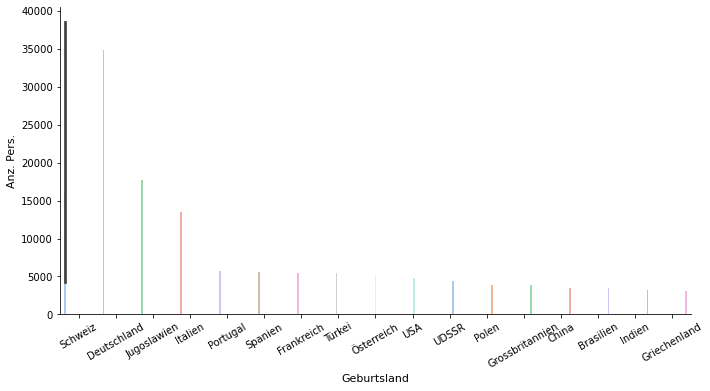

In [76]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="GebLandHistLang"
            , y="sum_WBev"
            , hue="GebLandHistLang"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index().query('sum_WBev > 3000')
           )
myHist.set_xticklabels(rotation=30) 
myHist.set_xlabels('Geburtsland', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


In [77]:
#help(sns.catplot)     

In [78]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

In [79]:
myAggBar = data2betested.query('GebLandHistLang =="Schweiz"')\
    .groupby(['StichtagDatJahr','GebOrtHistCd', 'GebOrtHistLang']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('sum_WBev', ascending=False) 

myAggBar.reset_index().query('sum_WBev > 4000')

,StichtagDatJahr,GebOrtHistCd,GebOrtHistLang,sum_WBev
0,2020-01-01,261,Zürich,126647
1,2021-01-01,261,Zürich,126442
2,2019-01-01,261,Zürich,126356
3,2018-01-01,261,Zürich,125538
4,2017-01-01,261,Zürich,124583
...,...,...,...,...
178,2008-01-01,1061,Luzern,4042
179,2017-01-01,247,Schlieren,4039
180,2011-01-01,1061,Luzern,4027
181,2010-01-01,161,Zollikon,4012


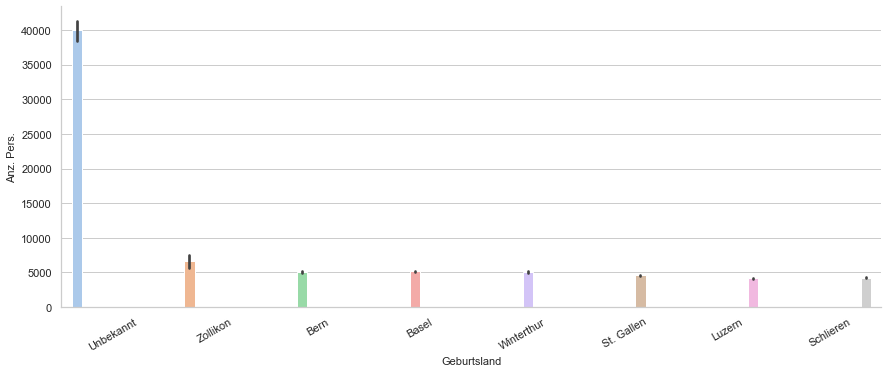

In [80]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="GebOrtHistLang"
            , y="sum_WBev"
            , hue="GebOrtHistLang"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2.5
            , order=None, legend_out=True
            ,data=myAggBar.reset_index().query('sum_WBev > 4000 & GebOrtHistLang !="Zürich"')
           )
myHist.set_xticklabels(rotation=30) 
myHist.set_xlabels('Geburtsland', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)

In [81]:
#data2betested.dtypes

## ---------------------- hier Plausi beendet

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=176&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

---------------------------------------------------------------------------